In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytrans.analysis import analyse_potential
from pytrans.analysis.analytic_traps import HarmonicTrap, QuarticTrap
from pytrans.plotting.plotting import _get_ion_color, _add_ions_legend


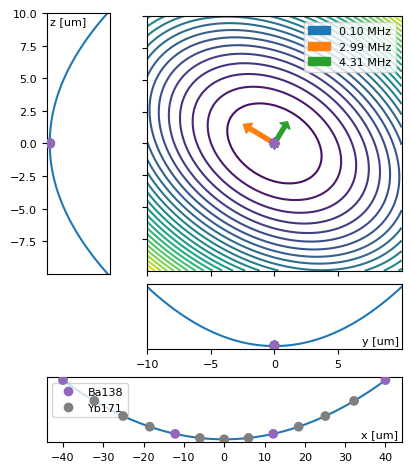

In [23]:
from pytrans.ions import Yb171, Ba138
from pytrans.analysis import analyse_potential

from pytrans.plotting.plotting import _get_ion_color, _add_ions_legend

# wx, wy, wz = 1.3e6, 3.5e6, 4.19e6
wx, wy, wz = -0.1e6, 3.396e6, 4.0e6
# trap = HarmonicTrap(wx, wy, wz, ion=Yb171, tilt_yz=0) + QuarticTrap(5e16)
trap = HarmonicTrap(abs(wx), wy, wz, ion=Yb171, tilt_yz=3e8)

ions = [Ba138, Yb171, Yb171, Yb171] * 3 + [Ba138]
roi = (40e-6, 1e-5, 1e-5)

res = analyse_potential(trap, voltages=None, ions=ions, ion1=Yb171, r0=(0, 0, 0), roi=roi, verbose=False)


In [24]:

def project_on_single_ion_modes(mode_vectors, single_ion_modes, keys=None):
    # projections of normal modes on single-ion eigenmodes
    proj = abs(np.einsum('Mai,mi', mode_vectors, single_ion_modes)).sum(1)
    mode1_index = np.argmax(proj, axis=1)

    mode_vectors_projected = np.asarray([mode_vectors[j] @ single_ion_modes[mode1_index[j]] for j in range(len(mode_vectors))])

    mode_labels = {}
    keys = 'xyz' if keys is None else keys
    for j, key in enumerate(keys):
        mode_labels[key] = np.where(mode1_index == j)[0]

    return mode_vectors_projected, mode_labels



In [25]:


trap_freqs = res.mode_freqs
mode_freqs = res.mode_solver_results.mode_freqs
mode_vectors = res.mode_solver_results.mode_vectors
x_eq = res.mode_solver_results.x_eq


v1 = res.mode_vectors
mode_vectors_proj, mode_labels = project_on_single_ion_modes(mode_vectors, v1, keys=['ax', 'r0', 'r1'])



In [28]:
mode_vectors.shape

(39, 13, 3)

In [30]:
mode_vectors_proj.shape

(39, 13)

In [27]:
mode_labels

{'ax': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
 'r0': array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64),
 'r1': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], dtype=int64)}

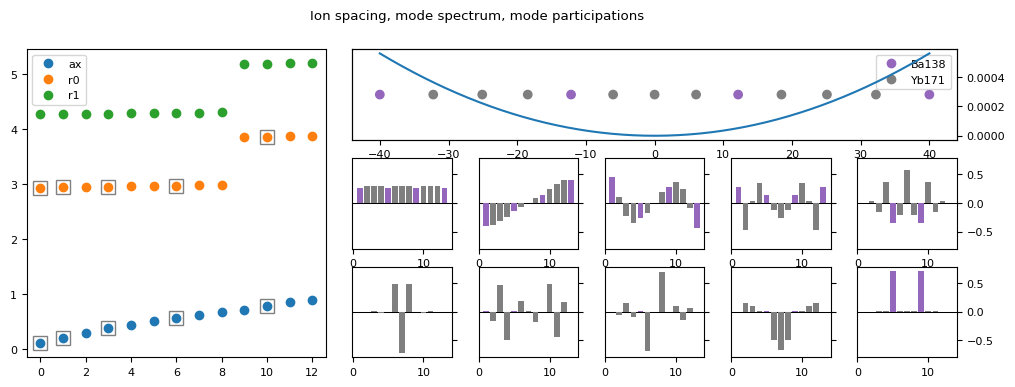

In [26]:

plot_modes = ['ax', 'r0']
plot_indices = [0, 1, 3, 6, 10]
# plot_indices = list(range(n_ions))

mosaic = [['freqs'] + [0] * (len(plot_indices))]
# mosaic += [['freqs'] * len(plot_indices)]
mosaic += [
    ['freqs'] + [f"{mode}_{j}" for j in plot_indices] for mode in plot_modes
]
wr = [3] + [1] * len(plot_indices)
fig, axes = plt.subplot_mosaic(mosaic, figsize=(12, 4), width_ratios=wr)
fig.suptitle('Ion spacing, mode spectrum, mode participations')

ax0 = axes[0]
x, y = x_eq[:, [0, 1]].T * 1e6
ion_colors = [_get_ion_color(ion) for ion in ions]
ax0.scatter(x, y, c=ion_colors)
if y.ptp() < 0.1:
    ax0.set_ylim(-0.6, 0.6)
ax0.set_yticks([])
_add_ions_legend(ax0, ions)

x0 = roi[0]
xx = np.linspace(-roi[0], roi[0], 200)
pot = trap.potential(None, xx, 0, 0, 1, pseudo=False)
ax1 = ax0.twinx()
ax1.plot(xx * 1e6, pot)

af = axes['freqs']
for mode in mode_labels.keys():
    fs = mode_freqs[mode_labels[mode]] * 1e-6
    af.plot(fs, 'o', label=mode)
af.legend()

for mode in plot_modes:
    mv1 = mode_vectors_proj[mode_labels[mode]]
    fs = mode_freqs[mode_labels[mode]] * 1e-6
    for j in plot_indices:
        m = mv1[j]
        ax = axes[f"{mode}_{j}"]
        ax.sharey(axes['ax_0'])
        ax.bar(np.arange(1, len(m) + 1), m, color=ion_colors)
        ax.axhline(0, color='k', lw=0.75, zorder=-1)

        af.plot(j, fs[j], 's', mfc='none', mec='gray', ms=10)
        ax.yaxis.tick_right()
        if j != plot_indices[-1]:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)
